# MUSE

## Imports

In [2]:
import tarfile
import os
from moviepy.editor import VideoFileClip
import os
from torch.utils.data import Dataset
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, Wav2Vec2Processor, Wav2Vec2Model
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib

device = 'cuda'

## Data

In [3]:
def extract_audio(input_video_path, output_audio_path):
    # Ensure that the output directory exists
    output_dir = os.path.dirname(output_audio_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the video file
    video = VideoFileClip(input_video_path)

    # Write audio directly to a file
    video.audio.write_audiofile(
        output_audio_path, fps=44100, verbose=False, logger=None)

    # Close the video clip
    video.close()

class MELDDataset(Dataset):
    """
    A simple Dataset for IEMOCAP-like data, where each entry has:
      - audio_path: Path to the .wav file
      - transcript: The text transcript
      - label: The emotion label (int)
    """

    def __init__(self, csv_file, root_dir='./data', transform=None, target_sr=16):
        """
        :param csv_file: Path to a CSV file (or txt) listing [audio_path, transcript, label].
        :param transform: Optional audio transform (torchaudio transforms or custom).
        """
        self.samples = []
        self.transform = transform

        df = pd.read_csv(f'{root_dir}/{csv_file}')
        for _, row in df.iterrows():
          file_name = f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}'
          video_path = f'{root_dir}/video/{file_name}.mp4'
          audio_path = f'{root_dir}/audio/{file_name}.wav'
          
          if not os.path.exists(audio_path) and os.path.exists(video_path):
            extract_audio(video_path, audio_path)
          
          self.samples.append((
            audio_path,
            row["Utterance"], 
            row["Emotion"],
            row['Sentiment']
          ))
          
    def get_emotions_dicts(self):
        """
        Returns two dictionaries:
        - int_to_str: Maps indices to emotion strings.
        - str_to_int: Maps emotion strings to indices.
        """
        labels = list(set([sample[2] for sample in self.samples]))
        int_to_str = {idx: label for idx, label in enumerate(labels)}
        str_to_int = {emotion: idx for idx, emotion in int_to_str.items()}
        return int_to_str, str_to_int

    def get_sentiments_dicts(self):
        """
        Returns two dictionaries:
        - int_to_str: Maps indices to sentiment strings.
        - str_to_int: Maps sentiment strings to indices.
        """
        labels = list(set([sample[3] for sample in self.samples]))
        int_to_str = {idx: label for idx, label in enumerate(labels)}
        str_to_int = {sentiment: idx for idx, sentiment in int_to_str.items()}
        return int_to_str, str_to_int

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, transcript, emotion, sentiment = self.samples[idx]

        emotion_to_int = self.get_emotions_dicts()[1]
        sentiment_to_int = self.get_sentiments_dicts()[1]

        audio_array, sr = librosa.load(audio_path)
        if self.transform:
            audio_array = self.transform(audio_array)

        return audio_array, sr, transcript, emotion_to_int[emotion], sentiment_to_int[sentiment]


In [34]:
# setup the dataset
orig_train_set = MELDDataset(
    csv_file="train_sent_emo.csv",
    root_dir="/kaggle/input/meld-train-muse"
)

dev_set = MELDDataset(
    csv_file="dev_sent_emo.csv",
    root_dir="/kaggle/input/meld-dev-muse"
)

test_set = MELDDataset(
    csv_file='test_sent_emo.csv',
    root_dir='/kaggle/input/meld-test-muse'
)

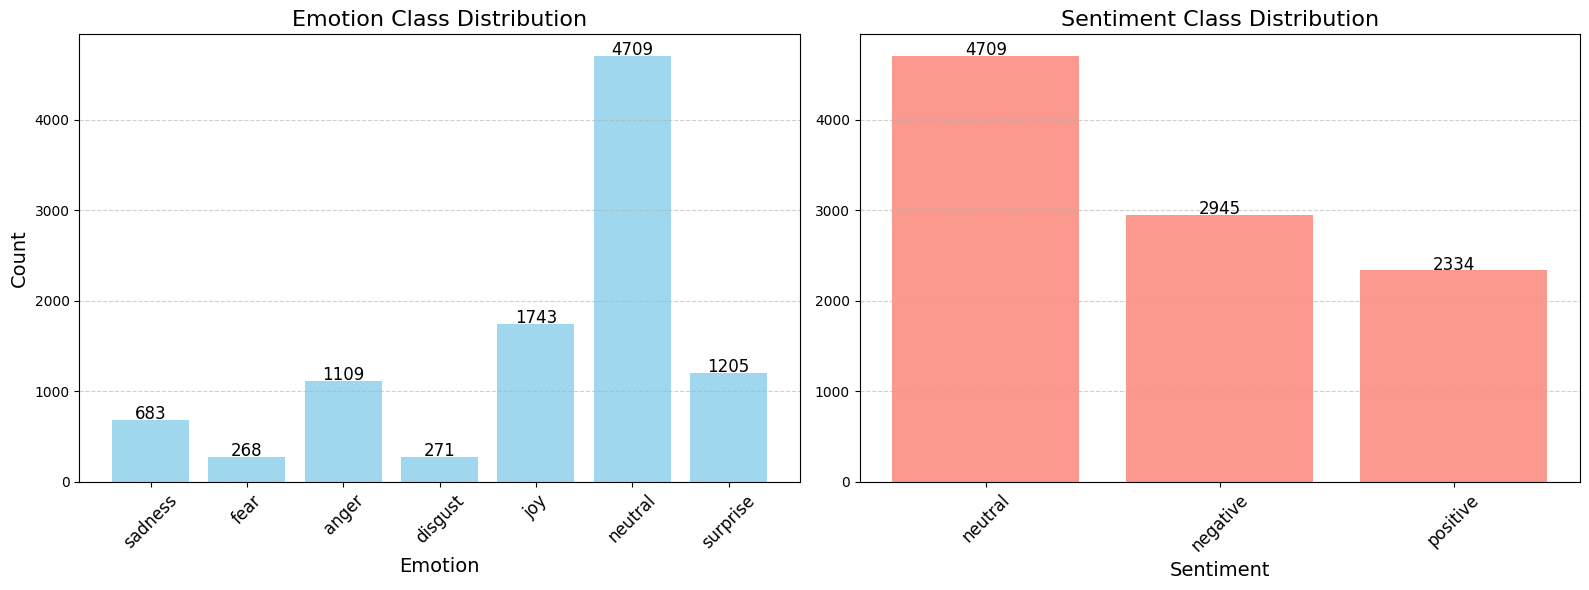

In [5]:
def show_class_distribution(dataset):
    """
    Displays the class distribution for emotions and sentiments as subplots
    with the counts displayed on top of the bars.

    :param dataset: An instance of the MELDDataset class.
    """
    # Get the mappings for emotion and sentiment
    int_to_emotion, _ = dataset.get_emotions_dicts()
    int_to_sentiment, _ = dataset.get_sentiments_dicts()

    # Initialize counters for emotions and sentiments
    emotion_counts = {emotion: 0 for emotion in int_to_emotion.values()}
    sentiment_counts = {sentiment: 0 for sentiment in int_to_sentiment.values()}

    # Count occurrences of each class in the dataset
    for _, _, emotion, sentiment in dataset.samples:
        emotion_counts[emotion] += 1
        sentiment_counts[sentiment] += 1

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    # Plot Emotion Distribution
    axes[0].bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue', alpha=0.8)
    axes[0].set_title("Emotion Class Distribution", fontsize=16)
    axes[0].set_xlabel("Emotion", fontsize=14)
    axes[0].set_ylabel("Count", fontsize=14)
    axes[0].tick_params(axis='x', rotation=45, labelsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    # Add counts on top of bars for emotions
    for i, value in enumerate(emotion_counts.values()):
        axes[0].text(i, value + 10, str(value), ha='center', fontsize=12, color='black')

    # Plot Sentiment Distribution
    axes[1].bar(sentiment_counts.keys(), sentiment_counts.values(), color='salmon', alpha=0.8)
    axes[1].set_title("Sentiment Class Distribution", fontsize=16)
    axes[1].set_xlabel("Sentiment", fontsize=14)
    axes[1].tick_params(axis='x', rotation=45, labelsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)

    # Add counts on top of bars for sentiments
    for i, value in enumerate(sentiment_counts.values()):
        axes[1].text(i, value + 10, str(value), ha='center', fontsize=12, color='black')

    # Adjust layout
    plt.tight_layout()
    plt.show()

show_class_distribution(orig_train_set)

In [6]:
audio_array, sr, transcript, emotion, sentiment = orig_train_set[1]

Audio(audio_array, rate=sr)

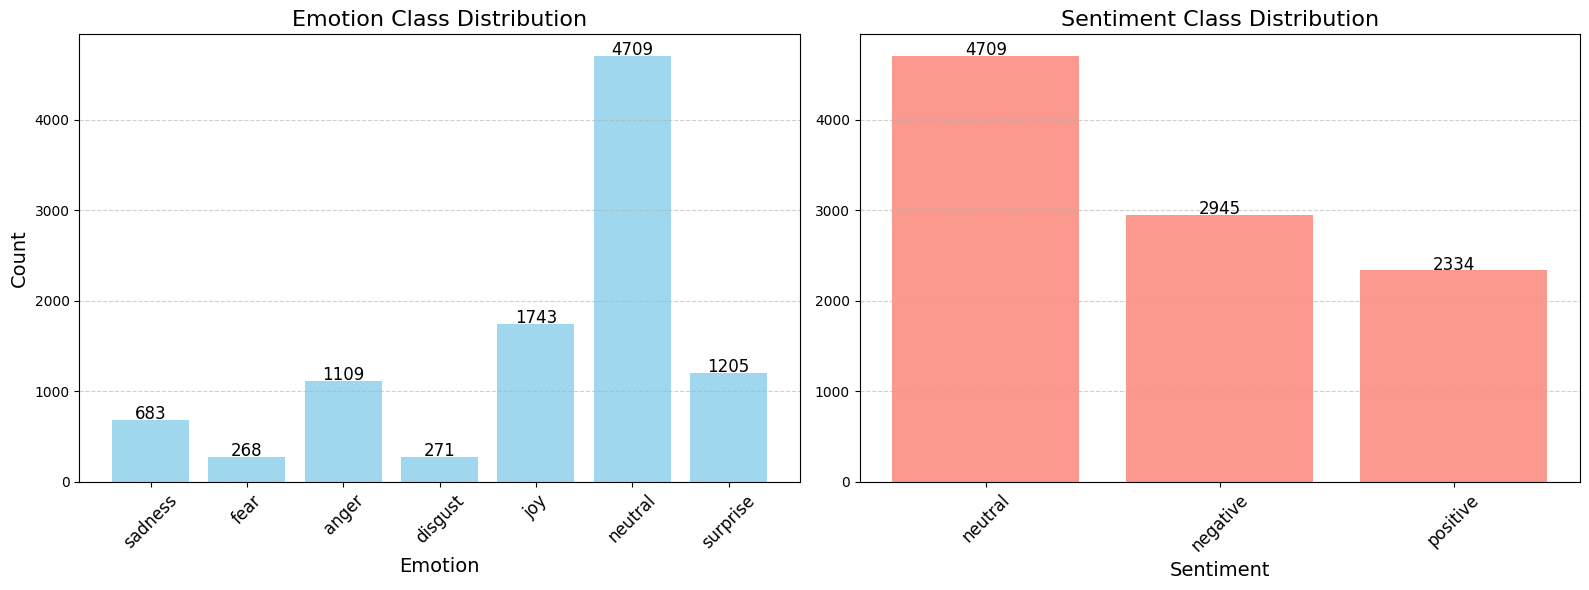

In [7]:
def remove_random_neutral_samples(dataset, num_to_remove=2000, random_seed=42):
    """
    Removes `num_to_remove` random samples with the emotion label "neutral" from the dataset.
    Ensures reproducibility by setting a random seed.

    :param dataset: An instance of the MELDDataset class.
    :param num_to_remove: Number of "neutral" samples to remove (default is 2000).
    :param random_seed: Seed for random number generation (default is 42).
    """
    ds = dataset
    
    # Filter indices of samples with the "neutral" label
    neutral_indices = [i for i, sample in enumerate(ds.samples) if sample[2] == "neutral"]

    # Ensure the number to remove does not exceed the available "neutral" samples
    if len(neutral_indices) < num_to_remove:
        print(f"Only {len(neutral_indices)} 'neutral' samples available. Removing all of them.")
        num_to_remove = len(neutral_indices)

    # Set random seed for reproducibility
    random.seed(random_seed)

    # Randomly select `num_to_remove` indices from the neutral samples
    indices_to_remove = random.sample(neutral_indices, num_to_remove)

    # Remove the selected samples from the dataset
    ds.samples = [sample for i, sample in enumerate(ds.samples) if i not in indices_to_remove]

    return ds

# train_set = MELDDataset(
#     csv_file="train_sent_emo.csv",
#     root_dir="/kaggle/input/meld-train-muse"
# )
# train_set = remove_random_neutral_samples(train_set) 
train_set = orig_train_set

In [8]:
print(f'Number of sentiments: {len(train_set.get_emotions_dicts()[0].values())}')
print(f'Number of emotions: {len(train_set.get_sentiments_dicts()[0].values())}')

Number of sentiments: 7
Number of emotions: 3


In [9]:
def get_subset(dataset, subset_size=100):
    # Randomly select indices for the subset
    subset_indices = torch.randperm(len(dataset))[:subset_size]
    
    # Create the subset
    train_subset = Subset(train_set, subset_indices)

    return train_subset

In [35]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Subset

def collate_fn(batch):
    """
    Custom collate function to handle variable-length audio inputs.
    Pads audio waveforms in the batch to the length of the longest waveform.
    """
    audio_arrays, sample_rates, texts, emotions, sentiments = zip(*batch)

    # Pad audio waveforms to the maximum length in the batch
    audio_arrays = [torch.tensor(audio) for audio in audio_arrays]
    audio_arrays_padded = pad_sequence(audio_arrays, batch_first=True, padding_value=0)

    # Convert labels to tensors
    emotions = torch.tensor(emotions)
    sentiments = torch.tensor(sentiments)

    return audio_arrays_padded, sample_rates, texts, emotions, sentiments

train_loader = DataLoader(
    train_set,
    batch_size=16,         # You can adjust the batch size
    shuffle=True,          # Shuffle data during training
    num_workers=4,         # Number of workers for parallel data loading
    collate_fn=collate_fn
)

subtrain_loader = DataLoader(
    get_subset(train_set),
    batch_size=16,         # You can adjust the batch size
    shuffle=True,          # Shuffle data during training
    num_workers=4,         # Number of workers for parallel data loading
    collate_fn=collate_fn
)

dev_loader = DataLoader(
    dev_set,
    batch_size=16,         # You can adjust the batch size
    shuffle=True,          # Shuffle data during training
    num_workers=4,         # Number of workers for parallel data loading
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_set,
    batch_size=16,         # You can adjust the batch size
    shuffle=True,          # Shuffle data during training
    num_workers=4,         # Number of workers for parallel data loading
    collate_fn=collate_fn
)

## Embeddings

In [11]:
class AudioEncoder(nn.Module):
    """
    Uses a Wav2Vec2 model to encode raw waveform into an audio embedding.
    """

    def __init__(self, model_name="facebook/wav2vec2-base", target_sr=16000, fine_tune=False, device='cuda'):
        """
        :param model_name: Hugging Face model name, e.g., "facebook/wav2vec2-base".
        :param target_sr: Sample rate the model expects, typically 16k.
        :param fine_tune: Whether we allow gradient updates in the model.
        """
        super(AudioEncoder, self).__init__()
        self.processor = Wav2Vec2Processor.from_pretrained(model_name)
        self.model = Wav2Vec2Model.from_pretrained(model_name).to(device)
        self.target_sr = target_sr

        if not fine_tune:
            # Freeze parameters
            for param in self.model.parameters():
                param.requires_grad = False

    def forward(self, waveforms, sample_rates):
        """
        :param waveforms: Tensor of shape [B, T] (batched waveforms)
        :param sample_rates: List of sample rates for each audio in the batch
        :return: A tensor of shape [B, hidden_dim] (audio embeddings for the batch)
        """
        batch_size = waveforms.size(0)
        processed_waveforms = []
        device = self.model.device

        # Resample each waveform in the batch
        for i in range(batch_size):
            waveform = waveforms[i]
            sample_rate = sample_rates[i]
            if sample_rate != self.target_sr:
                # Convert waveform to numpy, resample, then back to tensor
                waveform_np = waveform.cpu().numpy()
                waveform_np = librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=self.target_sr)
                waveform = torch.tensor(waveform_np)
            processed_waveforms.append(waveform)

        # Stack all processed waveforms into a batch
        waveforms = torch.stack(processed_waveforms).to(waveforms.device)
        
        # Process waveforms
        inputs = self.processor(
            waveforms.cpu(), 
            sampling_rate=self.target_sr, 
            return_tensors="pt", 
            padding=True
        ).input_values.squeeze((0, 1)).to(waveforms.device)
         
        with torch.no_grad() if not self.training or not any(
            p.requires_grad for p in self.model.parameters()
        ) else torch.enable_grad():
            outputs = self.model(inputs)
            hidden_states = outputs.last_hidden_state  # shape [B, T, D]

        # Average pooling across time dimension
        audio_emb = hidden_states.mean(dim=1)  # shape [B, D]

        return audio_emb
        
class TextEncoder(nn.Module):
    """
    Encodes text using a pretrained BERT model from Hugging Face.
    """

    def __init__(self, model_name="bert-base-uncased", fine_tune=False, device='cuda'):
        super(TextEncoder, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name).to(device)

        if not fine_tune:
            for param in self.model.parameters():
                param.requires_grad = False

    def forward(self, text_list):
        """
        :param text_list: A list of strings (or a single string) to encode.
        :return: A tensor of shape [batch_size, hidden_dim] with text embeddings
        """
        device = self.model.device
        
        # If a single string is passed, wrap it into a list
        if isinstance(text_list, str):
            text_list = [text_list]

        encodings = self.tokenizer(
            text_list, 
            padding=True, 
            truncation=True, 
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad() if not self.training or not any(
            p.requires_grad for p in self.model.parameters()
        ) else torch.enable_grad():
            outputs = self.model(
                input_ids=encodings.input_ids,
                attention_mask=encodings.attention_mask
            )

        # outputs.last_hidden_state -> shape [batch_size, seq_len, hidden_dim]
        # Using [CLS] token embedding as a single representation
        cls_emb = outputs.last_hidden_state[:, 0, :]  # shape [B, hidden_dim]
        return cls_emb

In [12]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class EmbeddingDataset(Dataset):
    def __init__(self, audio_embs, text_embs, emotion_labels, sentiment_labels):
        """
        :param audio_embs:    FloatTensor [N, audio_dim]
        :param text_embs:     FloatTensor [N, text_dim]
        :param emotion_labels: List of length N (ints or strings)
        :param sentiment_labels: List of length N (ints or strings)
        """
        self.audio_embs = audio_embs
        self.text_embs = text_embs
        self.emotion_labels = emotion_labels
        self.sentiment_labels = sentiment_labels

    def __len__(self):
        return len(self.audio_embs)

    def __getitem__(self, idx):
        return (
            self.audio_embs[idx], 
            self.text_embs[idx], 
            self.emotion_labels[idx], 
            self.sentiment_labels[idx]
        )

def build_embedding_dataset(dataloader, audio_encoder, text_encoder, device='cuda'):
    """
    Iterates over a DataLoader that yields (audio_arrays, srs, transcripts, emotion_labels, sentiment_labels)
    in batches, runs each batch through the frozen encoders, and returns an EmbeddingDataset.
    """
    audio_encoder.eval()
    text_encoder.eval()

    all_audio_embs = []
    all_text_embs = []
    all_emotions = []
    all_sentiments = []

    for audio_arrays, srs, transcripts, emotion_labels, sentiment_labels in dataloader:
        # audio_arrays: [B, T]
        # srs: list or 1D tensor of sample rates (length B)
        # transcripts: list of strings (length B)
        # emotion_labels, sentiment_labels: typically 1D tensors or lists

        # Move audio arrays to device
        audio_arrays = torch.tensor(audio_arrays).to(device)
        
        # Convert label tensors to Python lists (if needed)
        # so we can .extend() them below
        if isinstance(emotion_labels, torch.Tensor):
            emotion_labels = emotion_labels.tolist()
        if isinstance(sentiment_labels, torch.Tensor):
            sentiment_labels = sentiment_labels.tolist()

        with torch.no_grad():
            # 1) Audio embeddings (shape: [B, audio_dim])
            audio_emb = audio_encoder(audio_arrays, srs)

            # 2) Text embeddings (shape: [B, text_dim])
            text_emb = text_encoder(transcripts)

        # Collect embeddings on CPU
        all_audio_embs.append(audio_emb.cpu())
        all_text_embs.append(text_emb.cpu())

        # Collect labelsProcessor Usage: The processor is used on the CPU, but the resulting tensors are moved to the model's device before model inference.
        all_emotions.extend(emotion_labels)
        all_sentiments.extend(sentiment_labels)

    # Concatenate all batches into single tensors: [N, audio_dim] / [N, text_dim]
    audio_embs_tensor = torch.cat(all_audio_embs, dim=0)
    text_embs_tensor  = torch.cat(all_text_embs,  dim=0)

    # Build a new EmbeddingDataset that returns (audio_emb, text_emb, emotion, sentiment)
    emb_dataset = EmbeddingDataset(
        audio_embs_tensor, 
        text_embs_tensor, 
        all_emotions, 
        all_sentiments
    )
    return emb_dataset

In [13]:
audio_model_name = "facebook/wav2vec2-base"
text_model_name = "bert-base-uncased"

audio_encoder = AudioEncoder(model_name=audio_model_name)
text_encoder = TextEncoder(model_name=text_model_name)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
train_emb_dataset = build_embedding_dataset(train_loader, audio_encoder, text_encoder, device)
dev_emb_dataset   = build_embedding_dataset(dev_loader, audio_encoder, text_encoder, device)

In [41]:
test_emb_dataset = build_embedding_dataset(test_loader, audio_encoder, text_encoder, device)

## Model

In [16]:
from torch.profiler import profile, record_function, ProfilerActivity

class MultimodalClassifier(nn.Module):
    def __init__(self,
                 audio_model_name="facebook/wav2vec2-base",
                 text_model_name="bert-base-uncased",
                 audio_fine_tune=False,
                 text_fine_tune=False,
                 hidden_dim=768,
                 num_emotions=7,
                 num_sentiments=3):
        """
        :param audio_model_name: e.g., "facebook/wav2vec2-base"
        :param text_model_name: e.g., "bert-base-uncased"
        :param audio_fine_tune: whether to fine-tune the audio encoder
        :param text_fine_tune: whether to fine-tune the text encoder
        :param hidden_dim: dimension of the embeddings (depends on the model)
        :param num_classes: number of emotion classes (e.g., 4 for IEMOCAP: angry, happy, sad, neutral)
        """
        super(MultimodalClassifier, self).__init__()

        # Build encoders
        self.audio_model_name = audio_model_name
        self.text_model_name = text_model_name
        self.audio_encoder = AudioEncoder(model_name=audio_model_name, fine_tune=audio_fine_tune)
        self.text_encoder = TextEncoder(model_name=text_model_name, fine_tune=text_fine_tune)

        # If Wav2Vec2 base has 768 dims and BERT base has 768 dims -> total is 1536
        # If you use average pooling / CLS, that might remain 768 for each
        self.fusion_dim = hidden_dim * 2

        self.emotion_classifier = nn.Linear(self.fusion_dim, num_emotions)
        self.sentiment_classifier = nn.Linear(self.fusion_dim, num_sentiments)

    def forward(self, audio_array, sr, text):
        """
        :param waveform: Tensor of shape [1, T] or [B, 1, T] with audio waveforms
        :param sample_rate: int or list of ints (for multiple samples)
        :param text: list of strings or a single string
        :return: logits of shape [B, num_classes]
        """
        # 1) Audio embeddings
        audio_emb = self.audio_encoder(audio_array, sr)  # shape [1, D]

        # 2) Text embeddings
        text_emb = self.text_encoder(text)  # shape [B, D]
        # If it's a single item, shape might be [1, D]

        # 3) Fuse (concat)
        #fused = torch.cat([audio_emb, text_emb], dim=-1)  # shape [B, 2D]

        # 4) Classification
        #logits = self.classifier(fused)  # shape [B, num_classes]

        return audio_emb, text_emb

In [17]:
test_model = MultimodalClassifier(audio_fine_tune=False)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Sanity check for the model class

In [18]:
subtrain_loader = DataLoader(
    get_subset(train_set),
    batch_size=16,         # You can adjust the batch size
    shuffle=True,          # Shuffle data during training
    num_workers=4,         # Number of workers for parallel data loading
    collate_fn=collate_fn
)

# check
audio_arrays, srs, texts, _, _ = next(iter(train_loader))

output = test_model(audio_arrays.to(device), srs, texts)
output # the output is a tuple with both text and and audio embedding

(tensor([[-0.0677,  0.1053,  0.0686,  ...,  0.4211,  0.3038, -0.2891],
         [-0.0688,  0.1960,  0.4311,  ...,  0.2813,  0.2836, -0.0031],
         [-0.2301,  0.1167,  0.3966,  ...,  0.2962,  0.0482,  0.0459],
         ...,
         [ 0.1515,  0.0363, -0.0038,  ...,  0.5092,  0.2348, -0.4494],
         [ 0.0348,  0.0931, -0.0322,  ...,  0.1589,  0.3499, -0.3471],
         [ 0.2308, -0.1823,  0.2659,  ...,  0.3403,  0.2263, -0.0072]],
        device='cuda:0'),
 tensor([[ 0.1474, -0.0183, -0.1513,  ...,  0.0352,  0.4237,  0.4622],
         [-0.1308,  0.5325, -0.0670,  ..., -0.3422,  0.7382,  0.5418],
         [ 0.1305,  0.2382,  0.2051,  ...,  0.0300, -0.0392,  0.3033],
         ...,
         [-0.0904,  0.3319,  0.2936,  ..., -0.5042,  0.4084,  0.5863],
         [ 0.2069, -0.0984, -0.2675,  ..., -0.1246,  0.3011,  0.4613],
         [ 0.2963,  0.0274, -0.3619,  ..., -0.0653,  0.3525,  0.6841]],
        device='cuda:0'))

## Training

In [19]:
def process_task(model, a, t, classifier, weight_size, labels, criterion, device='cuda'):
    """
    Helper function to process a single task (e.g., emotion or sentiment).
    
    Parameters
    ----------
    model        : your model
    a            : audio embeddings
    t            : text embeddings
    classifier   : the classifier layer (e.g., model.emotion_classifier)
    weight_size  : dimensionality to split classifier weights (for audio vs. text)
    labels       : ground-truth labels
    criterion    : PyTorch loss function (e.g., CrossEntropyLoss)
    device       : device to run computations on

    Returns
    -------
    loss              : computed loss for this task
    preds_fused       : predicted classes from fused embeddings
    preds_audio       : predicted classes from audio embeddings
    preds_text        : predicted classes from text embeddings
    """
    fused = torch.cat([a, t], dim=-1)

    # --- Compute logits ---
    logits_fused = classifier(fused)

    # 2) Audio-only
    logits_a = (
        torch.mm(a, torch.transpose(classifier.weight[:, : weight_size // 2], 0, 1))
        + classifier.bias / 2
    )

    # 3) Text-only
    logits_t = (
        torch.mm(t, torch.transpose(classifier.weight[:, weight_size // 2 :], 0, 1))
        + classifier.bias / 2
    )

    # --- Compute loss ---
    loss = criterion(logits_fused, labels)

    # --- Predictions ---
    preds_fused = torch.argmax(logits_fused, dim=1).detach().cpu().numpy()
    preds_audio = torch.argmax(logits_a,      dim=1).detach().cpu().numpy()
    preds_text  = torch.argmax(logits_t,      dim=1).detach().cpu().numpy()

    return loss, preds_fused, preds_audio, preds_text

In [20]:
def train_one_epoch(model, dataloader, optimizer, criterions, emotion_reg=0.5, sentiment_reg=0.5, device='cuda'): 
    model.train()

    # tracked measures
    losses = {'emotion': 0.0, 'sentiment': 0.0}
    metrics = {'emotion': {'fused': [], 'audio': [], 'text': [], 'labels': []},
               'sentiment': {'fused': [], 'audio': [], 'text': [], 'labels': []}}

    # For splitting the classifier weights
    emotion_weight_size   = model.emotion_classifier.weight.size(1)
    sentiment_weight_size = model.sentiment_classifier.weight.size(1)

    # for audio_arrays, sr, texts, emotion_labels, sentiment_labels in dataloader:
    for a, t, emotion_labels, sentiment_labels in dataloader:
        # Move data to device
        # audio_arrays = audio_arrays.to(device)
        a = a.to(device)
        t = t.to(device)
        emotion_labels = emotion_labels.to(device)
        sentiment_labels = sentiment_labels.to(device)

        optimizer.zero_grad()

        # -- Get audio and text embeddings from the model --
        # a, t = model(audio_arrays, sr, texts)

        # ============================ EMOTION ============================
        emotion_loss, e_fused, e_audio, e_text = process_task(
                model=model, a=a, t=t, classifier=model.emotion_classifier,
                weight_size=model.emotion_classifier.weight.size(1),
                labels=emotion_labels, criterion=criterions['emotion']
        )
        losses['emotion'] += emotion_loss.item()
        metrics['emotion']['fused'].extend(e_fused)
        metrics['emotion']['audio'].extend(e_audio)
        metrics['emotion']['text'].extend(e_text)
        metrics['emotion']['labels'].extend(emotion_labels.cpu().numpy())

        # ============================ SENTIMENT ============================
        sentiment_loss, s_fused, s_audio, s_text = process_task(
                model=model, a=a, t=t, classifier=model.sentiment_classifier,
                weight_size=model.sentiment_classifier.weight.size(1),
                labels=sentiment_labels, criterion=criterions['sentiment']
        )
        losses['sentiment'] += sentiment_loss.item()
        metrics['sentiment']['fused'].extend(s_fused)
        metrics['sentiment']['audio'].extend(s_audio)
        metrics['sentiment']['text'].extend(s_text)
        metrics['sentiment']['labels'].extend(sentiment_labels.cpu().numpy())

        # ============================ UPDATE ============================
        # Weighted combination of emotion and sentiment losses
        combined_loss = emotion_reg * emotion_loss + sentiment_reg * sentiment_loss
        combined_loss.backward()
        optimizer.step()

    # Average losses
    losses['emotion'] /= len(dataloader)
    losses['sentiment'] /= len(dataloader)

    # compute metrics per modality and 
    emotion_metrics = {
        'fused': compute_metrics(metrics['emotion']['labels'], metrics['emotion']['fused']),
        'audio': compute_metrics(metrics['emotion']['labels'], metrics['emotion']['audio']),
        'text': compute_metrics(metrics['emotion']['labels'], metrics['emotion']['text']),
    }
    sentiment_metrics = {
        'fused': compute_metrics(metrics['sentiment']['labels'], metrics['sentiment']['fused']),
        'audio': compute_metrics(metrics['sentiment']['labels'], metrics['sentiment']['audio']),
        'text': compute_metrics(metrics['sentiment']['labels'], metrics['sentiment']['text']),
    }
    
    return losses, {'emotion': emotion_metrics, 'sentiment': sentiment_metrics}

def validate_one_epoch(model, dataloader, criterions, device='cuda'):
    model.eval()

    # Initialize tracking variables
    losses = {'emotion': 0.0, 'sentiment': 0.0}
    metrics = {'emotion': {'fused': [], 'audio': [], 'text': [], 'labels': []},
               'sentiment': {'fused': [], 'audio': [], 'text': [], 'labels': []}}

    # Weight sizes
    emotion_weight_size   = model.emotion_classifier.weight.size(1)
    sentiment_weight_size = model.sentiment_classifier.weight.size(1)

    with torch.no_grad():
        # for audio_arrays, sr, texts, emotion_labels, sentiment_labels in dataloader:
        for a, t, emotion_labels, sentiment_labels in dataloader:
            # Move data to device
            # audio_arrays = audio_arrays.to(device)
            a = a.to(device)
            t = t.to(device)
            emotion_labels = emotion_labels.to(device)
            sentiment_labels = sentiment_labels.to(device)

            # Obtain embeddings
            # a, t = model(audio_arrays, sr, texts)

            # ------------------- EMOTION TASK -------------------
            # Process Emotion Task
            emotion_loss, e_fused, e_audio, e_text = process_task(
                model=model, a=a, t=t, classifier=model.emotion_classifier,
                weight_size=model.emotion_classifier.weight.size(1),
                labels=emotion_labels, criterion=criterions['emotion']
            )
            losses['emotion'] += emotion_loss.item()
            metrics['emotion']['fused'].extend(e_fused)
            metrics['emotion']['audio'].extend(e_audio)
            metrics['emotion']['text'].extend(e_text)
            metrics['emotion']['labels'].extend(emotion_labels.cpu().numpy())

            # ------------------ SENTIMENT TASK ------------------
            sentiment_loss, s_fused, s_audio, s_text = process_task(
                model=model, a=a, t=t, classifier=model.sentiment_classifier,
                weight_size=model.sentiment_classifier.weight.size(1),
                labels=sentiment_labels, criterion=criterions['sentiment']
            )
            losses['sentiment'] += sentiment_loss.item()
            metrics['sentiment']['fused'].extend(s_fused)
            metrics['sentiment']['audio'].extend(s_audio)
            metrics['sentiment']['text'].extend(s_text)
            metrics['sentiment']['labels'].extend(sentiment_labels.cpu().numpy())
            
        # Average losses
        losses['emotion'] /= len(dataloader)
        losses['sentiment'] /= len(dataloader)
    
        # Compute metrics
        emotion_metrics = {
            'fused': compute_metrics(metrics['emotion']['labels'], metrics['emotion']['fused']),
            'audio': compute_metrics(metrics['emotion']['labels'], metrics['emotion']['audio']),
            'text': compute_metrics(metrics['emotion']['labels'], metrics['emotion']['text']),
        }
        sentiment_metrics = {
            'fused': compute_metrics(metrics['sentiment']['labels'], metrics['sentiment']['fused']),
            'audio': compute_metrics(metrics['sentiment']['labels'], metrics['sentiment']['audio']),
            'text': compute_metrics(metrics['sentiment']['labels'], metrics['sentiment']['text']),
        }

    return losses, {'emotion': emotion_metrics, 'sentiment': sentiment_metrics}


def compute_metrics(true_labels, predictions):
    """
    Compute classification metrics including accuracy, per-class F1 scores, and weighted average F1 score.
    """
    # Compute overall accuracy
    overall_accuracy = accuracy_score(true_labels, predictions)

    # Compute F1 scores
    report = classification_report(
        true_labels, predictions, output_dict=True, zero_division=0
    )
    per_class_f1 = {label: values["f1-score"] for label, values in report.items() if label.isdigit()}
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    # Compile metrics into a dictionary
    metrics = {
        "acc": overall_accuracy,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "per_class_f1": per_class_f1,
    }

    return metrics

def task_result_to_table(task_result):
    df = pd.DataFrame([
        {
            'epoch': res['epoch'],
            'train_loss': res['train_loss'],
            'val_loss': res['val_loss'],
            **flatten_metrics(res['train_metrics'], prefix='train'),
            **flatten_metrics(res['val_metrics'], prefix='val')
        }
        for res in task_result
    ])
    
    return df

def flatten_metrics(metrics, prefix=''):
    """
    Flatten metrics for easier storage in a tabular format.

    :param metrics: Dictionary of metrics (e.g., {'fused': {...}, 'audio': {...}, 'text': {...}})
    :param prefix: Prefix for column names (optional, e.g., 'train' or 'val').
    :return: Flattened dictionary.
    """
    flattened = {}
    for modality, modality_metrics in metrics.items():
        for metric_name, value in modality_metrics.items():
            flattened[f"{prefix}_{modality}_{metric_name}"] = value
    return flattened

def train_and_validate(model, train_loader, val_loader, optimizer, criterions, num_epochs, experiment_name, device='cuda', save_dir='./results'):
    """
    Train and validate the model for multiple epochs, and display results in a summary table at the end.

    :param model: The model to train.
    :param train_dataloader: Training DataLoader.
    :param val_dataloader: Validation DataLoader.
    :param optimizer: Optimizer.
    :param criterion: Loss function.
    :param num_epochs: Number of epochs.
    :param model_name: Name of the model (for display in results).
    :param device: Device to use for training ('cuda' or 'cpu').
    """
    os.makedirs(save_dir, exist_ok=True)
    
    results = {
        'experiment_name': experiment_name,
        'model_state_dict': None,
        'results_emotions': [],
        'results_sentiments': []
    }

    for epoch in range(num_epochs):
        train_losses, train_metrics = train_one_epoch(model, train_loader, optimizer, criterions, device=device)
        val_losses, val_metrics = validate_one_epoch(model, val_loader, criterions, device=device)

        if epoch % 20 == 0 or epoch == num_epochs:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            for task in ['emotion', 'sentiment']:
                print(f"\t{task.capitalize()} Train Loss: {train_losses[task]:.4f}")
                print(f"\t{task.capitalize()} Val Loss:   {val_losses[task]:.4f}")
                for modality in ['fused', 'audio', 'text']:
                    train_acc = train_metrics[task][modality]['acc'] * 100
                    val_acc = val_metrics[task][modality]['acc'] * 100
                    train_f1 = train_metrics[task][modality]['macro_f1'] * 100
                    val_f1 = val_metrics[task][modality]['macro_f1'] * 100
                    print(f"\t\t{modality.capitalize()} Train Acc: {train_acc:.2f}%, Train F1 (macro): {train_f1:.2f}%")
                    print(f"\t\t{modality.capitalize()} Val Acc:   {val_acc:.2f}%, Val F1 (macro):   {val_f1:.2f}%")
                    print('\n')
            print("---------------------------------------------------------------\n")

        # Save results for both tasks
        results['results_emotions'].append({
            'epoch': epoch + 1,
            'train_loss': train_losses['emotion'],
            'val_loss': val_losses['emotion'],
            'train_metrics': train_metrics['emotion'],
            'val_metrics': val_metrics['emotion']
        })
        results['results_sentiments'].append({
            'epoch': epoch + 1,
            'train_loss': train_losses['sentiment'],
            'val_loss': val_losses['sentiment'],
            'train_metrics': train_metrics['sentiment'],
            'val_metrics': val_metrics['sentiment']
        })

    # Save model state
    results['model_state_dict'] = model.state_dict()
    results['optimizer'] = optimizer

    # save all the results as pkl file
    results_joblib_path = os.path.join(save_dir, f"{experiment_name}_bsize{train_loader.batch_size}.pkl")
    joblib.dump(results, results_joblib_path)

    # display the summary of the training as a Datframe (a table per task)
    print('\n\n SUMMARY OF THE RESULTS\n')
    for task in ['emotions', 'sentiments']:
        print(f'Results for the {task} task:')
        display(task_result_to_table(results[f'results_{task}']))
    print(f"Results saved as Joblib file: {results_joblib_path}.")
    
    # Display final results in a table
    return model, results

In [21]:
# Gather all emotion labels in the train set
emotion_labels = [sample[2] for sample in train_set.samples]

# Count how many samples of each class (returns unique labels and their counts)
unique_classes, counts = np.unique(emotion_labels, return_counts=True)
print("Class labels:", unique_classes)
print("Class counts:", counts)

# Example output might look like:
# Class labels: ['joy' 'neutral' 'sadness' 'anger' ...]
# Class counts: [ 120,  300,  180,  100, ...]

# Convert class strings to the same indices you use for training
# (If you used get_emotions_dicts, you can do str_to_int)
_, str_to_int = train_set.get_emotions_dicts()

# Re-order counts so they align with the same integer index you use in your model
# e.g. label 0 = 'neutral', label 1 = 'joy', etc.
num_classes = len(str_to_int)
ordered_counts = [0] * num_classes

for class_label, count in zip(unique_classes, counts):
    class_idx = str_to_int[class_label]   # Convert 'neutral' → 0, 'joy' → 1, etc.
    ordered_counts[class_idx] = count

ordered_counts = np.array(ordered_counts)
print("Ordered counts:", ordered_counts)

# Avoid division by zero
inverse_freq = 1.0 / np.maximum(ordered_counts, 1)

#joy, fear, disgust, surprise, sadness, neutral, anger


Class labels: ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
Class counts: [1109  271  268 1743 4709  683 1205]
Ordered counts: [ 683  268 1109  271 1743 4709 1205]


In [22]:
emotions_class_weights = torch.tensor(inverse_freq, dtype=torch.float32)
# or normalize them
emotions_class_weights = emotions_class_weights / emotions_class_weights.sum() #* num_classes

print("Class weights:", emotions_class_weights)
emotions_class_weights = emotions_class_weights.to(device)

Class weights: tensor([0.1284, 0.3272, 0.0791, 0.3236, 0.0503, 0.0186, 0.0728])


In [23]:
lr = 0.0001
criterions = {
    'emotion': nn.CrossEntropyLoss(weight=emotions_class_weights),
    'sentiment': nn.CrossEntropyLoss()
}
num_epochs = 50
num_emotions = len(train_set.get_emotions_dicts()[0].values())
num_sentiments = len(train_set.get_sentiments_dicts()[0].values())
model = MultimodalClassifier(
    text_fine_tune=False,
    audio_fine_tune=False, 
    num_emotions=num_emotions,
    num_sentiments=num_sentiments
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


experiment_name = f'wav2vec2_bert_init'
batch_size = 16

train_emb_loader = DataLoader(
    train_emb_dataset,
    batch_size=batch_size, 
    shuffle=True,          
    num_workers=4,         
)

dev_emb_loader = DataLoader(
    dev_emb_dataset,
    batch_size=batch_size, 
    shuffle=True,          
    num_workers=4,         
)

model, results = train_and_validate(
    model, train_emb_loader, dev_emb_loader, 
    optimizer, criterions, num_epochs, 
    experiment_name=experiment_name, 
    device='cuda', save_dir='/kaggle/working/'
)
print("Training complete.")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/50]
	Emotion Train Loss: 1.8382
	Emotion Val Loss:   1.9104
		Fused Train Acc: 42.24%, Train F1 (macro): 25.74%
		Fused Val Acc:   46.30%, Val F1 (macro):   28.85%


		Audio Train Acc: 17.91%, Train F1 (macro): 11.62%
		Audio Val Acc:   12.82%, Val F1 (macro):   8.43%


		Text Train Acc: 40.22%, Train F1 (macro): 23.71%
		Text Val Acc:   45.22%, Val F1 (macro):   27.79%


	Sentiment Train Loss: 0.9517
	Sentiment Val Loss:   0.9116
		Fused Train Acc: 56.29%, Train F1 (macro): 44.92%
		Fused Val Acc:   59.84%, Val F1 (macro):   54.15%


		Audio Train Acc: 47.07%, Train F1 (macro): 24.27%
		Audio Val Acc:   42.51%, Val F1 (macro):   21.17%


		Text Train Acc: 59.60%, Train F1 (macro): 53.55%
		Text Val Acc:   60.38%, Val F1 (macro):   57.18%


---------------------------------------------------------------

Epoch [21/50]
	Emotion Train Loss: 1.3845
	Emotion Val Loss:   2.0138
		Fused Train Acc: 56.14%, Train F1 (macro): 44.14%
		Fused Val Acc:   48.56%, Val F1 (macro):   36.10%



,epoch,train_loss,val_loss,train_fused_acc,train_fused_macro_f1,train_fused_weighted_f1,train_fused_per_class_f1,train_audio_acc,train_audio_macro_f1,train_audio_weighted_f1,...,val_fused_weighted_f1,val_fused_per_class_f1,val_audio_acc,val_audio_macro_f1,val_audio_weighted_f1,val_audio_per_class_f1,val_text_acc,val_text_macro_f1,val_text_weighted_f1,val_text_per_class_f1
0,1,1.838177,1.910400,0.422407,0.257434,0.433561,"{'0': 0.17765814266487218, '1': 0.017441860465...",0.179115,0.116173,0.166909,...,0.439301,"{'0': 0.2875816993464052, '1': 0.0, '2': 0.157...",0.128159,0.084259,0.119514,"{'0': 0.0, '1': 0.0, '2': 0.06666666666666667,...",0.452166,0.277873,0.425989,"{'0': 0.32022471910112354, '1': 0.0, '2': 0.12..."
1,2,1.704807,1.952795,0.509011,0.337960,0.520165,"{'0': 0.23588205897051473, '1': 0.054187192118...",0.198939,0.108696,0.171479,...,0.452184,"{'0': 0.21965317919075147, '1': 0.0, '2': 0.15...",0.143502,0.077452,0.128570,"{'0': 0.0, '1': 0.0, '2': 0.07364341085271318,...",0.488267,0.316876,0.461585,"{'0': 0.2962962962962963, '1': 0.0245398773006..."
2,3,1.633627,1.866638,0.530336,0.362030,0.539796,"{'0': 0.27181544633901705, '1': 0.082872928176...",0.195835,0.100884,0.164575,...,0.459959,"{'0': 0.3293172690763052, '1': 0.0236686390532...",0.106498,0.056201,0.081739,"{'0': 0.0, '1': 0.0, '2': 0.06196213425129088,...",0.459386,0.322141,0.450044,"{'0': 0.3313609467455621, '1': 0.0457142857142..."
3,4,1.590172,1.816961,0.532139,0.380019,0.546584,"{'0': 0.28586065573770497, '1': 0.121475054229...",0.189728,0.103012,0.155149,...,0.472746,"{'0': 0.37777777777777777, '1': 0.063492063492...",0.119134,0.067229,0.116358,"{'0': 0.0, '1': 0.0, '2': 0.06980273141122913,...",0.458484,0.331181,0.460253,"{'0': 0.3567251461988305, '1': 0.0909090909090..."
4,5,1.556993,1.935264,0.537445,0.386896,0.552386,"{'0': 0.29509906152241916, '1': 0.135593220338...",0.194033,0.103168,0.155960,...,0.473654,"{'0': 0.3694779116465864, '1': 0.0238095238095...",0.161552,0.093892,0.168677,"{'0': 0.0, '1': 0.0, '2': 0.06408094435075885,...",0.459386,0.325485,0.454122,"{'0': 0.3510971786833856, '1': 0.0451977401129..."
5,6,1.534431,1.866750,0.545755,0.401196,0.559975,"{'0': 0.3043712898003238, '1': 0.1630901287553...",0.222867,0.115845,0.204910,...,0.466367,"{'0': 0.3537906137184115, '1': 0.0231213872832...",0.131769,0.081058,0.122207,"{'0': 0.0, '1': 0.0, '2': 0.05813953488372093,...",0.451264,0.328875,0.454230,"{'0': 0.3511904761904762, '1': 0.0808080808080..."
6,7,1.511441,1.850048,0.547257,0.407775,0.563917,"{'0': 0.30533544638140514, '1': 0.183823529411...",0.214858,0.114911,0.188554,...,0.471370,"{'0': 0.3836734693877551, '1': 0.0531914893617...",0.148014,0.084411,0.139971,"{'0': 0.0, '1': 0.0, '2': 0.065439672801636, '...",0.445848,0.330522,0.454561,"{'0': 0.35064935064935066, '1': 0.108597285067..."
7,8,1.496129,1.879709,0.548058,0.411765,0.565611,"{'0': 0.3083466241360978, '1': 0.1869488536155...",0.238386,0.122763,0.220401,...,0.471036,"{'0': 0.3878326996197719, '1': 0.0333333333333...",0.128159,0.070526,0.128659,"{'0': 0.0, '1': 0.0, '2': 0.06504065040650406,...",0.445848,0.329301,0.454414,"{'0': 0.35555555555555557, '1': 0.095238095238..."
8,9,1.478762,1.881616,0.547257,0.411613,0.564819,"{'0': 0.31171662125340605, '1': 0.175862068965...",0.221266,0.116953,0.195826,...,0.487921,"{'0': 0.3944954128440367, '1': 0.0534759358288...",0.140794,0.082185,0.135476,"{'0': 0.0, '1': 0.0, '2': 0.06589147286821705,...",0.450361,0.330501,0.459239,"{'0': 0.3732394366197183, '1': 0.0900900900900..."
9,10,1.470145,1.813835,0.555266,0.421651,0.573506,"{'0': 0.3183540877097997, '1': 0.1961471103327...",0.224569,0.120514,0.197607,...,0.471796,"{'0': 0.38866396761133604, '1': 0.090497737556...",0.110108,0.069397,0.095898,"{'0': 0.01694915254237288, '1': 0.0, '2': 0.06...",0.426895,0.329983,0.446136,"{'0': 0.36, '1': 0.13432835820895522, '2': 0.1..."


Results for the sentiments task:


,epoch,train_loss,val_loss,train_fused_acc,train_fused_macro_f1,train_fused_weighted_f1,train_fused_per_class_f1,train_audio_acc,train_audio_macro_f1,train_audio_weighted_f1,...,val_fused_weighted_f1,val_fused_per_class_f1,val_audio_acc,val_audio_macro_f1,val_audio_weighted_f1,val_audio_per_class_f1,val_text_acc,val_text_macro_f1,val_text_weighted_f1,val_text_per_class_f1
0,1,0.951749,0.911608,0.562875,0.449160,0.505461,"{'0': 0.6992250565062965, '1': 0.3974940591920...",0.470665,0.242658,0.326658,...,0.565141,"{'0': 0.7134693877551019, '1': 0.4584717607973...",0.425090,0.211663,0.261713,"{'0': 0.5982028241335045, '1': 0.0049140049140...",0.603791,0.571789,0.591791,"{'0': 0.707089552238806, '1': 0.51532033426183..."
1,2,0.850436,0.864356,0.643773,0.580489,0.618537,"{'0': 0.754223047669585, '1': 0.52713783678250...",0.474169,0.236363,0.319409,...,0.600656,"{'0': 0.7315834038950042, '1': 0.5064935064935...",0.424188,0.212429,0.261401,"{'0': 0.5980707395498392, '1': 0.0, '2': 0.039...",0.611011,0.582481,0.601558,"{'0': 0.7104761904761906, '1': 0.5300546448087..."
2,3,0.813591,0.834560,0.655887,0.602593,0.636728,"{'0': 0.7604251839738349, '1': 0.5470869149952...",0.474870,0.233789,0.317818,...,0.614571,"{'0': 0.7311072056239016, '1': 0.5414201183431...",0.426895,0.208437,0.260607,"{'0': 0.598978288633461, '1': 0.00980392156862...",0.616426,0.589383,0.610408,"{'0': 0.713717693836978, '1': 0.55443037974683..."
3,4,0.794751,0.814464,0.662795,0.614678,0.646825,"{'0': 0.7641404805914972, '1': 0.5592167200150...",0.473068,0.229155,0.313578,...,0.609544,"{'0': 0.7274352100089366, '1': 0.5413105413105...",0.425090,0.203578,0.256453,"{'0': 0.5974522292993631, '1': 0.0049140049140...",0.624549,0.597005,0.619080,"{'0': 0.7188755020080322, '1': 0.5721393034825..."
4,5,0.780775,0.799997,0.666099,0.620979,0.651629,"{'0': 0.7645197319434103, '1': 0.5640546100617...",0.474069,0.225880,0.311731,...,0.613589,"{'0': 0.7308377896613191, '1': 0.5544554455445...",0.424188,0.201813,0.254491,"{'0': 0.5970719287078294, '1': 0.0, '2': 0.008...",0.620036,0.594693,0.616005,"{'0': 0.709480122324159, '1': 0.57459926017262..."
5,6,0.773453,0.798229,0.669904,0.627041,0.656655,"{'0': 0.7670822007685818, '1': 0.5667910447761...",0.473368,0.226968,0.311978,...,0.626400,"{'0': 0.738544474393531, '1': 0.55667144906743...",0.423285,0.198519,0.252090,"{'0': 0.5955555555555555, '1': 0.0, '2': 0.0}",0.625451,0.601758,0.622329,"{'0': 0.7125256673511294, '1': 0.5824039653035..."
6,7,0.767201,0.800039,0.672807,0.630893,0.660269,"{'0': 0.7689843602788768, '1': 0.5743380855397...",0.473368,0.223313,0.309558,...,0.630884,"{'0': 0.7400722021660651, '1': 0.5644699140401...",0.423285,0.198519,0.252090,"{'0': 0.5955555555555555, '1': 0.0, '2': 0.0}",0.629964,0.605769,0.626848,"{'0': 0.7147270854788877, '1': 0.5921375921375..."
7,8,0.761369,0.784949,0.677413,0.636987,0.665589,"{'0': 0.7708451503119684, '1': 0.5842241061555...",0.472467,0.220573,0.307255,...,0.629267,"{'0': 0.7404718693284935, '1': 0.5637393767705...",0.423285,0.198519,0.252090,"{'0': 0.5955555555555555, '1': 0.0, '2': 0.0}",0.634477,0.609350,0.630841,"{'0': 0.7192622950819673, '1': 0.5970515970515..."
8,9,0.756849,0.799776,0.678314,0.638555,0.667071,"{'0': 0.7726970244319802, '1': 0.5832876211373...",0.473769,0.225889,0.311682,...,0.616653,"{'0': 0.7363796133567662, '1': 0.5290519877675...",0.423285,0.198519,0.252090,"{'0': 0.5955555555555555, '1': 0.0, '2': 0.0}",0.638087,0.613619,0.632950,"{'0': 0.7281746031746033, '1': 0.5811518324607..."
9,10,0.753024,0.781901,0.679816,0.639523,0.668085,"{'0': 0.7740775780510879, '1': 0.5833951074870...",0.473668,0.222899,0.309274,...,0.644173,"{'0': 0.7441424554826617, '1': 0.5893587994542...",0.421480,0.197923,0.251334,"{'0': 0.5937698664971391, '1': 0.0, '2': 0.0}",0.644404,0.622656,0.643153,"{'0': 0.7238095238095237, '1': 0.6159420289855..."


Results saved as Joblib file: /kaggle/working/wav2vec2_bert_init_bsize16.pkl.
Training complete.


### sanity check for the saved results

## Evaluate

In [25]:
from pprint import pprint

# Load the Joblib file
loaded_results = joblib.load('/kaggle/working/wav2vec2_bert_init_bsize16.pkl')

In [36]:
def plot_metrics(results, task='emotions', metric='acc', modality='fused'):
    """
    Plots metrics (e.g., accuracy or F1 score) for a specific task and modality over epochs.
    
    :param results: Dictionary containing training and validation results.
    :param task: Task name ('emotion' or 'sentiment').
    :param metric: Metric to plot (e.g., 'acc', 'macro_f1', 'weighted_f1').
    :param modality: Modality to plot ('fused', 'audio', 'text').
    """
    train_values = [
        epoch_results['train_metrics'][modality][metric] 
        for epoch_results in results[f'results_{task}']
    ]
    val_values = [
        epoch_results['val_metrics'][modality][metric] 
        for epoch_results in results[f'results_{task}']
    ]
    epochs = list(range(1, len(train_values) + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_values, label=f'Train {metric.capitalize()}', marker='o')
    plt.plot(epochs, val_values, label=f'Val {metric.capitalize()}', marker='o')
    plt.title(f'{task.capitalize()} {metric.capitalize()} ({modality.capitalize()})')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

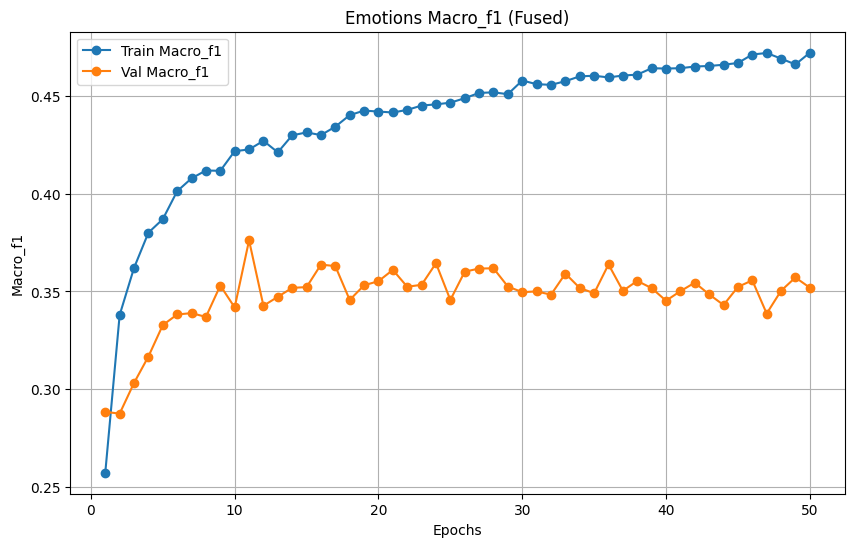

In [37]:
plot_metrics(loaded_results, metric='macro_f1', modality='fused', task='emotions')

In [55]:
def test_and_save_labels(model, test_loader, dataset, criterions, save_path, device='cuda'):
    """
    Perform inference on the test set and save the true and predicted labels to a file.

    :param model: The trained model.
    :param test_loader: DataLoader for the test set (the embedding one)
    :param criterions: Dictionary of loss functions for each task.
    :param save_path: Path to save the true and predicted labels.
    :param device: Device to use for inference ('cuda' or 'cpu').
    """
    model.eval()

    true_and_pred_labels = {
        'emotion': {'true': [], 'pred': []},
        'sentiment': {'true': [], 'pred': []},
    }

    e_int_to_str, e_str_to_int = dataset.get_emotions_dicts()
    s_int_to_str, s_str_to_int = dataset.get_emotions_dicts()

    with torch.no_grad():
        for a, t, emotion_labels, sentiment_labels in test_loader:
            # Move data to device
            a = a.to(device)
            t = t.to(device)
            emotion_labels = emotion_labels.to(device)
            sentiment_labels = sentiment_labels.to(device)

            # ------------------- EMOTION TASK -------------------
            _, e_fused, _, _ = process_task(
                model=model, a=a, t=t, classifier=model.emotion_classifier,
                weight_size=model.emotion_classifier.weight.size(1),
                labels=emotion_labels, criterion=criterions['emotion']
            )
            true_and_pred_labels['emotion']['true'].extend(emotion_labels.cpu().numpy())
            true_and_pred_labels['emotion']['pred'].extend(e_fused)

            # ------------------ SENTIMENT TASK ------------------
            _, s_fused, _, _ = process_task(
                model=model, a=a, t=t, classifier=model.sentiment_classifier,
                weight_size=model.sentiment_classifier.weight.size(1),
                labels=sentiment_labels, criterion=criterions['sentiment']
            )
            true_and_pred_labels['sentiment']['true'].extend(sentiment_labels.cpu().numpy())
            true_and_pred_labels['sentiment']['pred'].extend(s_fused)

    return true_and_pred_labels

In [56]:
criterions = {
    'emotion': nn.CrossEntropyLoss(weight=emotions_class_weights),
    'sentiment': nn.CrossEntropyLoss()
}
test_emb_loader = DataLoader(
    test_emb_dataset,
    batch_size=batch_size, 
    shuffle=True,          
    num_workers=4,         
)
true_and_pred_labels = test_and_save_labels(model, test_emb_loader, test_set, criterions, save_path='/kaggle/working')

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

def analyze_results_per_class(true_labels, predicted_labels, class_names, task_name="Sentiment", mode="confusion_matrix"):
    """
    Analyze results per class with confusion matrix, classification report, or ROC curves.

    Args:
        true_labels (list or np.ndarray): True labels for the task.
        predicted_labels (list or np.ndarray): Predicted labels from the model.
        class_names (list): List of class names.
        task_name (str): Name of the task (e.g., "Sentiment" or "Emotion").
        mode (str): The type of analysis. Options: "confusion_matrix", "classification_report", "roc_curve".
    """
    if mode == "confusion_matrix":
        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names)))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix for {task_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.show()

    elif mode == "classification_report":
        # Print classification report
        report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0)
        print(f"Classification Report for {task_name}:\n")
        print(report)

    elif mode == "roc_curve":
        # Compute and plot ROC curves
        true_binarized = label_binarize(true_labels, classes=range(len(class_names)))
        predicted_binarized = label_binarize(predicted_labels, classes=range(len(class_names)))
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(true_binarized[:, i], predicted_binarized[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--")  # Random baseline
        plt.title(f"ROC Curve for {task_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()

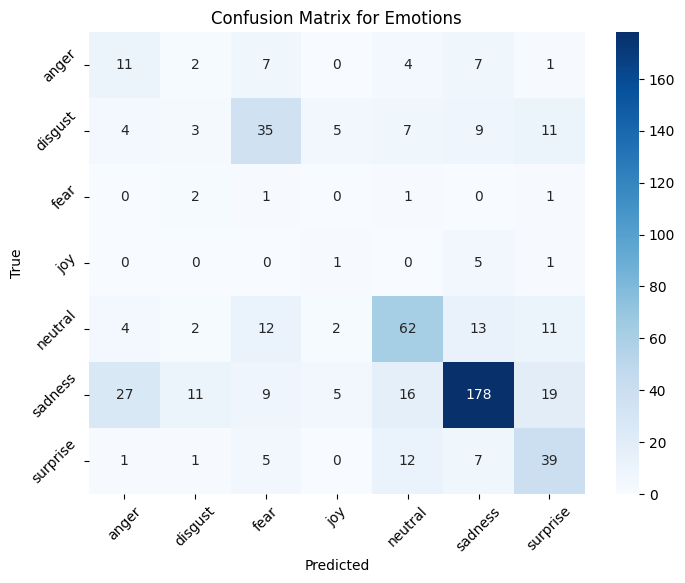

Classification Report for Emotions:

              precision    recall  f1-score   support

       anger       0.23      0.34      0.28        32
     disgust       0.14      0.04      0.06        74
        fear       0.01      0.20      0.03         5
         joy       0.08      0.14      0.10         7
     neutral       0.61      0.58      0.60       106
     sadness       0.81      0.67      0.74       265
    surprise       0.47      0.60      0.53        65

    accuracy                           0.53       554
   macro avg       0.34      0.37      0.33       554
weighted avg       0.59      0.53      0.55       554



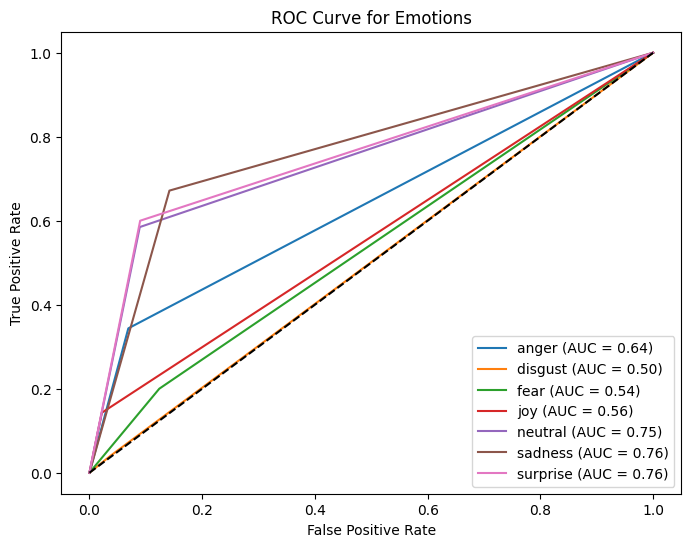

In [80]:
for mode in ['confusion_matrix', 'classification_report', 'roc_curve']:
    analyze_results_per_class(
        true_and_pred_labels['emotion']['true'], 
        true_and_pred_labels['emotion']['pred'], 
        unique_classes,
        task_name="Emotions",
        mode=mode
    )